#This is a solution for the Kaggle Titanic Competetion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,  BaggingClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.shape

(891, 12)

In [ ]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df.drop('Cabin', axis=1, inplace=True)
df.dropna(inplace=True)

In [ ]:
df.shape

(712, 11)

In [ ]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [ ]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
scaler = StandardScaler()
#encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#encoder = LabelEncoder()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
preprocessor = ColumnTransformer([
    ('scaler', scaler, num_cols),
    ('encoder', encoder, cat_cols)
])

In [ ]:
X_new = pd.DataFrame(preprocessor.fit_transform(X))
X_new.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.731479,0.908600,-0.527669,0.522511,-0.506787,-0.516380,103.0,1.0,407.0,2.0
1,-1.727611,-1.482983,0.577094,0.522511,-0.506787,0.694046,179.0,0.0,470.0,0.0
2,-1.723742,0.908600,-0.251478,-0.552714,-0.506787,-0.503620,317.0,0.0,531.0,2.0
3,-1.719874,-1.482983,0.369951,0.522511,-0.506787,0.350326,247.0,0.0,39.0,2.0
4,-1.716005,0.908600,0.369951,-0.552714,-0.506787,-0.501257,15.0,1.0,372.0,2.0


In [ ]:
l1 = Lasso(alpha=0.001)
l1.fit(X_new, y)
columns_to_drop = [column for column, coefficient in zip(X_new.columns, l1.coef_) if abs(coefficient) < 0.001]
X_new = X_new.drop(columns=columns_to_drop)

In [ ]:
X_new.shape

(712, 8)

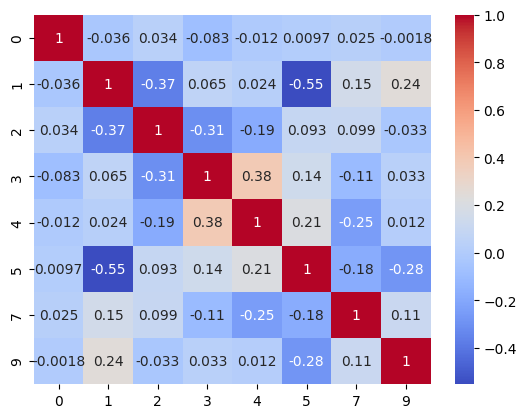

In [ ]:
sns.heatmap(X_new.corr(), annot=True, cmap="coolwarm")
plt.show()

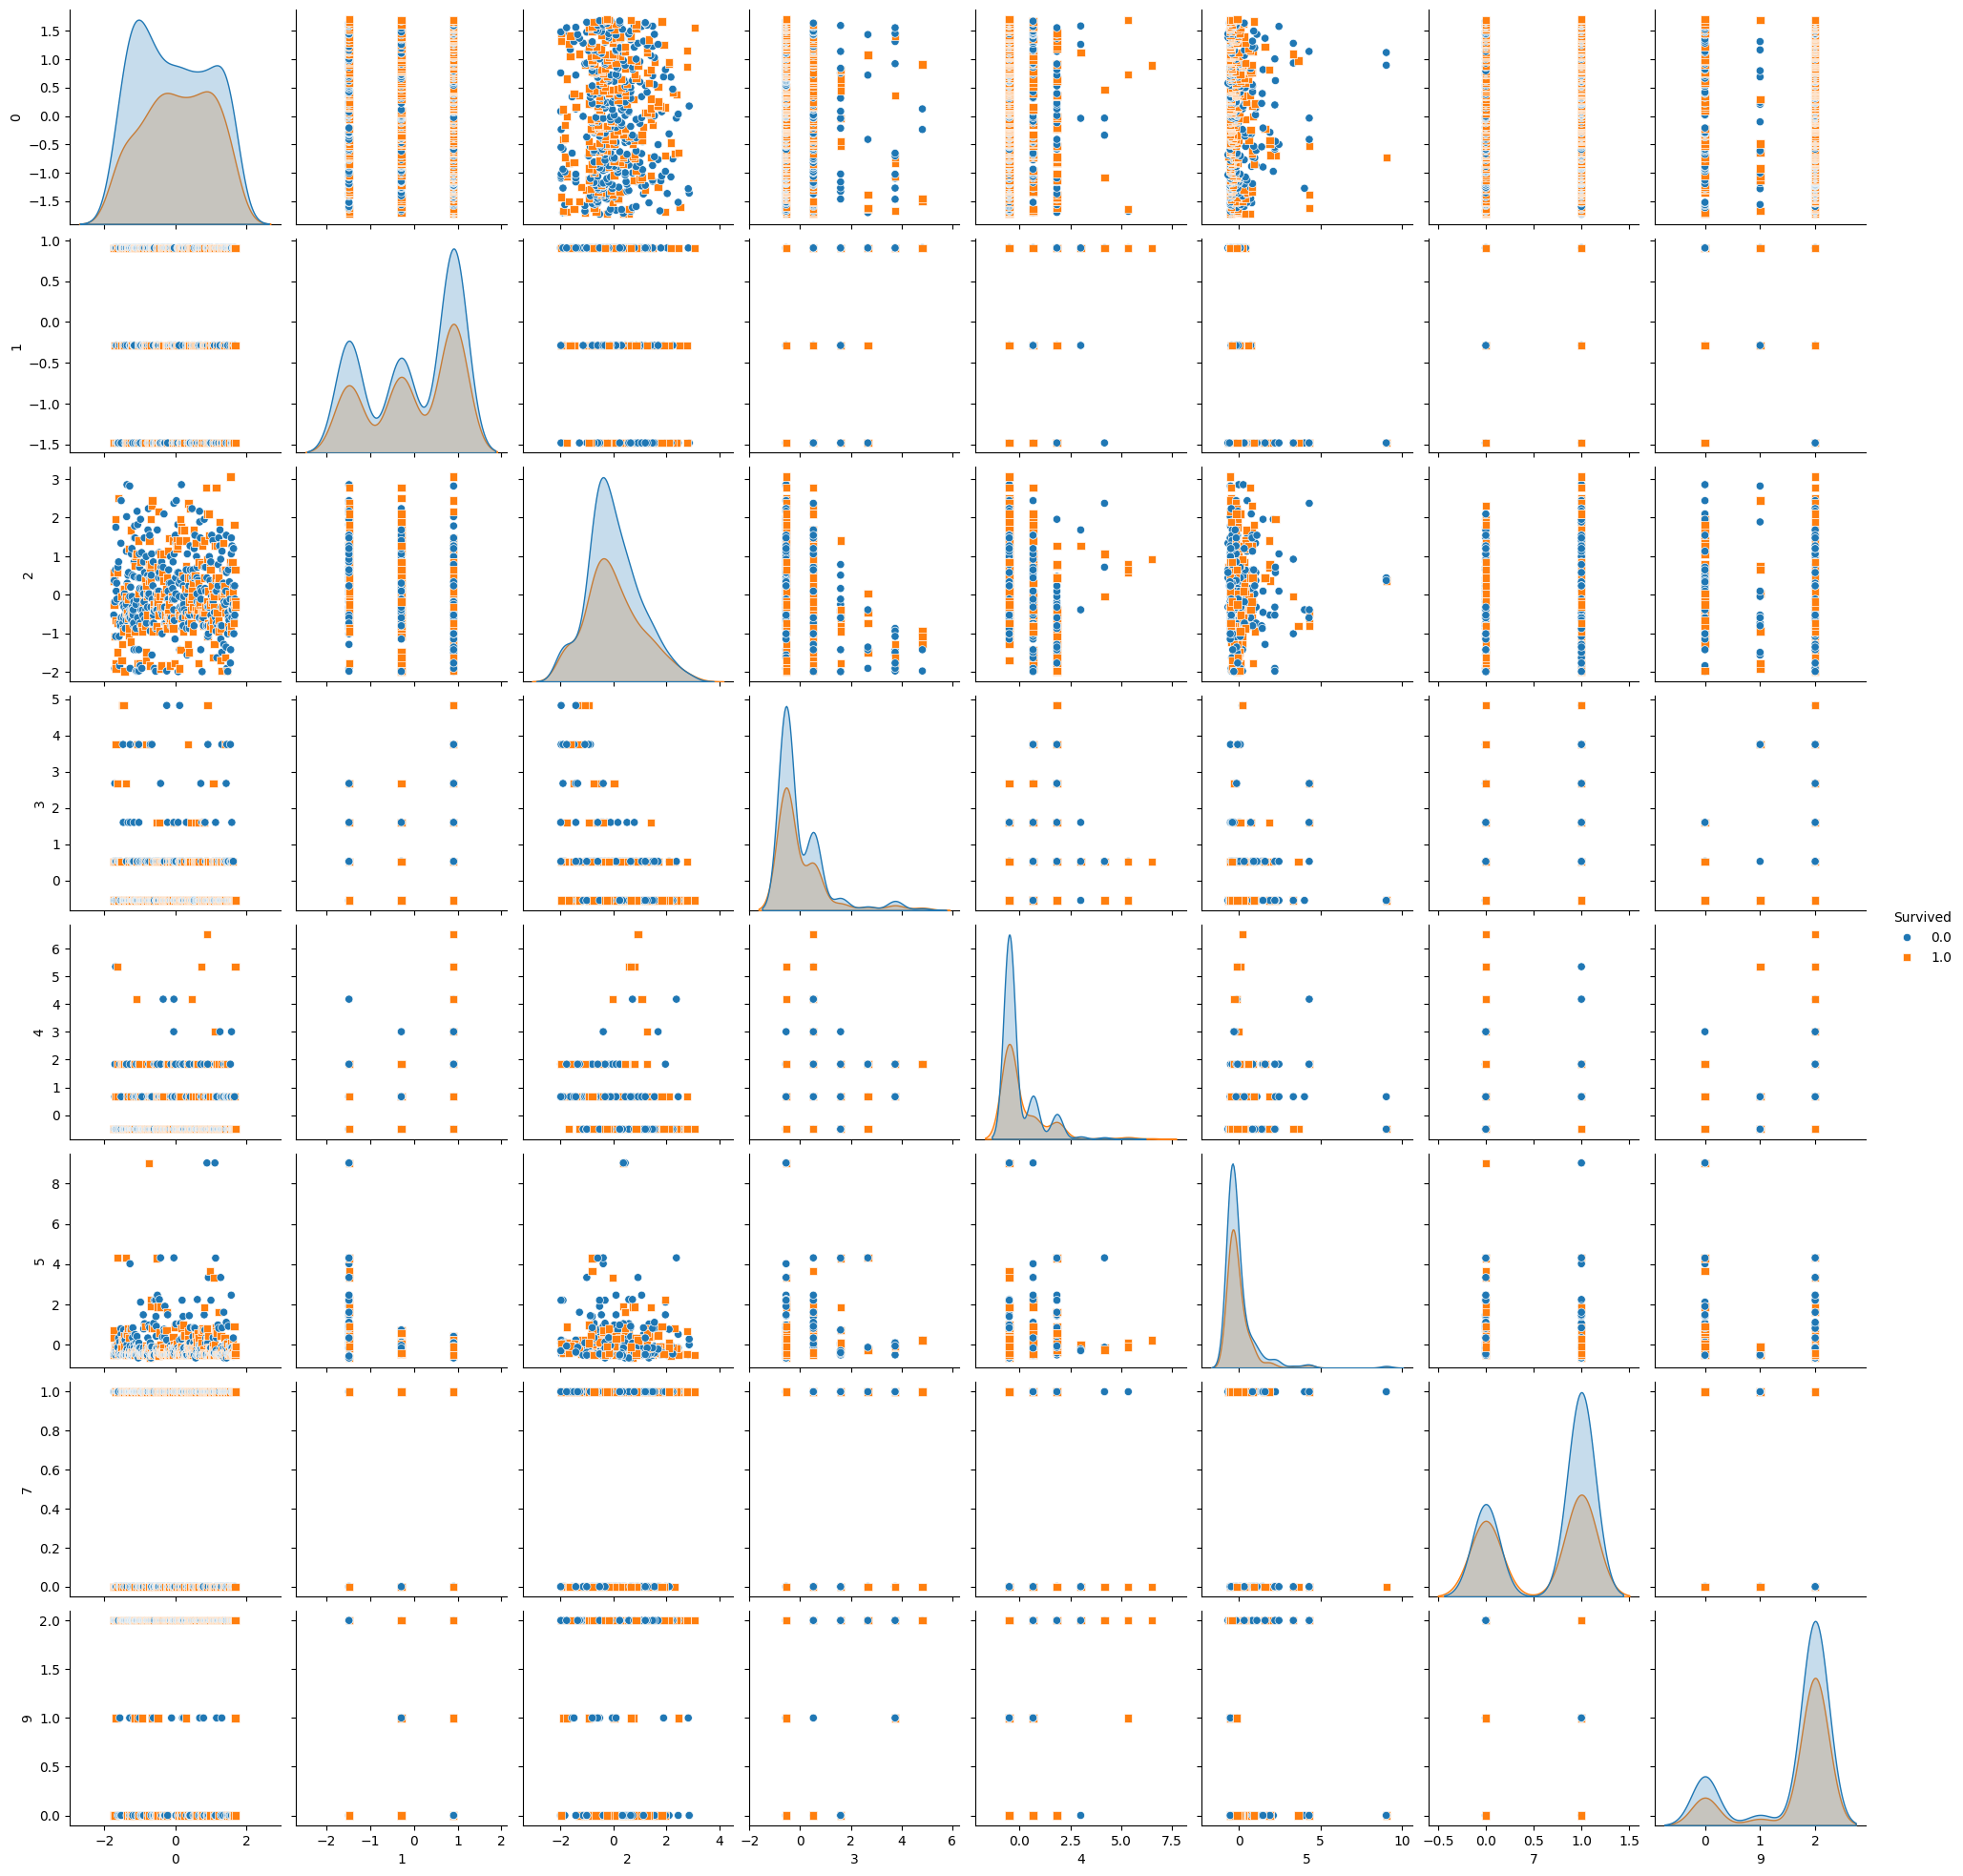

In [ ]:
combined_data = pd.concat([X_new, y], axis=1)
sns.pairplot(combined_data, hue="Survived", markers=['o', 's'])
plt.show()

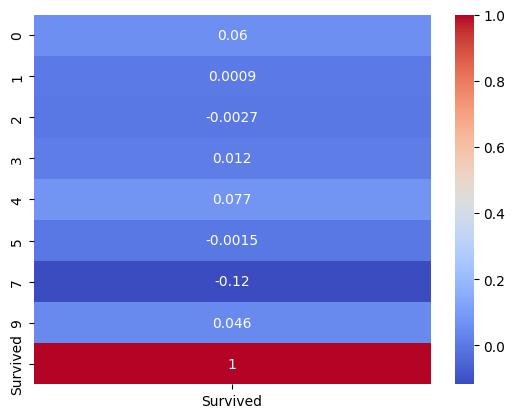

In [ ]:
sns.heatmap(combined_data.corr()[['Survived']], annot=True, cmap="coolwarm")
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

In [ ]:
svc = SVC()
grid_param = {
    'C': [0.1, 10, 1000],
    'gamma': [1, 0.1, 0.0001],
    'kernel': ['rbf']
}
grid = GridSearchCV(estimator=svc, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_svc = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_svc.predict(X_test))}")
bagged_svc = BaggingClassifier(estimator=best_svc, n_estimators=10, random_state=0)
bagged_svc.fit(X_train, Y_train)
print(f"Bagged SVC: {accuracy_score(Y_test, bagged_svc.predict(X_test))}")
boosted_svc = AdaBoostClassifier(estimator=best_svc, n_estimators=10, random_state=0, algorithm="SAMME")
boosted_svc.fit(X_train, Y_train)
print(f"Boosted SVC: {accuracy_score(Y_test, boosted_svc.predict(X_test))}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.7832167832167832
Bagged SVC: 0.7902097902097902
Boosted SVC: 0.6923076923076923


In [ ]:
knn = KNeighborsClassifier()
grid_param = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid = GridSearchCV(estimator=knn, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_knn = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_knn.predict(X_test))}")
bagged_knn = BaggingClassifier(estimator=best_knn, n_estimators=10, random_state=0)
bagged_knn.fit(X_train, Y_train)
print(f"Bagged KNN: {accuracy_score(Y_test, bagged_knn.predict(X_test))}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.7762237762237763
Bagged KNN: 0.8041958041958042


In [ ]:
forest = RandomForestClassifier()
grid_param = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(estimator=forest, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_forest = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_forest.predict(X_test))}")
bagged_forest = BaggingClassifier(estimator=best_forest, n_estimators=10, random_state=0)
bagged_forest.fit(X_train, Y_train)
print(f"Bagged Forest: {accuracy_score(Y_test, bagged_forest.predict(X_test))}")
boosted_forest = AdaBoostClassifier(estimator=best_forest, n_estimators=10, random_state=0)
boosted_forest.fit(X_train, Y_train)
print(f"Boosted Forest: {accuracy_score(Y_test, boosted_forest.predict(X_test))}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8251748251748252
Bagged Forest: 0.8391608391608392
Boosted Forest: 0.8391608391608392


In [ ]:
logistic = LogisticRegression(max_iter=1000)
grid_param = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 10, 1000]
}
grid = GridSearchCV(estimator=logistic, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_logistic = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_logistic.predict(X_test))}")
bagged_logistic = BaggingClassifier(estimator=best_logistic, n_estimators=10, random_state=0)
bagged_logistic.fit(X_train, Y_train)
print(f"Bagged Logistic: {accuracy_score(Y_test, bagged_logistic.predict(X_test))}")
boosted_logistic = AdaBoostClassifier(estimator=best_logistic, n_estimators=10, random_state=0)
boosted_logistic.fit(X_train, Y_train)
print(f"Boosted Logistic: {accuracy_score(Y_test, boosted_logistic.predict(X_test))}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.8111888111888111
Bagged Logistic: 0.8041958041958042
Boosted Logistic: 0.6083916083916084


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [ ]:
naive = GaussianNB()
grid_param = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}
grid = GridSearchCV(estimator=naive, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_naive = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_naive.predict(X_test))}")
bagged_naive = BaggingClassifier(estimator=best_naive, n_estimators=10, random_state=0)
bagged_naive.fit(X_train, Y_train)
print(f"Bagged Naive: {accuracy_score(Y_test, bagged_naive.predict(X_test))}")
boosted_naive = AdaBoostClassifier(estimator=best_naive, n_estimators=10, random_state=0)
boosted_naive.fit(X_train, Y_train)
print(f"Boosted Naive: {accuracy_score(Y_test, boosted_naive.predict(X_test))}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params: {'var_smoothing': 1e-09}
Accuracy: 0.7412587412587412
Bagged Naive: 0.7272727272727273
Boosted Naive: 0.6713286713286714


In [ ]:
tree = DecisionTreeClassifier()
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(estimator=tree, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_tree = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_tree.predict(X_test))}")
bagged_tree = BaggingClassifier(estimator=best_tree, n_estimators=10, random_state=0)
bagged_tree.fit(X_train, Y_train)
print(f"Bagged Tree: {accuracy_score(Y_test, bagged_tree.predict(X_test))}")
boosted_tree = AdaBoostClassifier(estimator=best_tree, n_estimators=10, random_state=0)
boosted_tree.fit(X_train, Y_train)
print(f"Boosted Tree: {accuracy_score(Y_test, boosted_tree.predict(X_test))}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
Accuracy: 0.8111888111888111
Bagged Tree: 0.7972027972027972
Boosted Tree: 0.6993006993006993


In [ ]:
estimators_voting = [
        ('boosted_forest', boosted_forest),
        ('bagged_svc', bagged_svc),
        ('best_logistic', best_logistic),
        ('best_tree', best_tree),
        ]

voting_classifier = VotingClassifier(estimators = estimators_voting, voting = 'hard')
voting_classifier.fit(X_train, Y_train)
print(f"Voting Score: {accuracy_score(Y_test, voting_classifier.predict(X_test))}")
bagged_voting_classifier = BaggingClassifier(estimator=voting_classifier, n_estimators=10, random_state=0)
bagged_voting_classifier.fit(X_train, Y_train)
print(f"Bagged Voting: {accuracy_score(Y_test, bagged_voting_classifier.predict(X_test))}")
boosted_voting_classifier = AdaBoostClassifier(estimator=voting_classifier, n_estimators=10, random_state=0, algorithm="SAMME")
boosted_voting_classifier.fit(X_train, Y_train)
print(f"Boosted Voting: {accuracy_score(Y_test, boosted_voting_classifier.predict(X_test))}")

Voting Score: 0.8181818181818182
Bagged Voting: 0.8041958041958042
Boosted Voting: 0.8181818181818182


In [ ]:
estimators_stacking = [
        ('boosted_forest', boosted_forest),
        ('bagged_svc', bagged_svc),
        ('best_logistic', best_logistic),
        ('best_tree', best_tree),
        ]
stacking_classifier = StackingClassifier(estimators=estimators_stacking, final_estimator=best_forest)
stacking_classifier.fit(X_train, Y_train)
print(f"Stacking Score: {accuracy_score(Y_test, voting_classifier.predict(X_test))}")
bagged_stacking = BaggingClassifier(estimator=voting_classifier, n_estimators=10, random_state=0)
bagged_stacking.fit(X_train, Y_train)
print(f"Bagged Stacking: {accuracy_score(Y_test, bagged_stacking.predict(X_test))}")
boosted_stacking = AdaBoostClassifier(estimator=voting_classifier, n_estimators=10, random_state=0, algorithm="SAMME")
boosted_stacking.fit(X_train, Y_train)
print(f"Boosted Stacking: {accuracy_score(Y_test, boosted_stacking.predict(X_test))}")

Stacking Score: 0.8181818181818182
Bagged Stacking: 0.8041958041958042
Boosted Stacking: 0.8181818181818182


In [ ]:
gb_clf = GradientBoostingClassifier()
grid_param = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.0035, 0.01],
    'max_depth': [5, 10, 15]
}
grid = GridSearchCV(estimator=gb_clf, param_grid=grid_param, cv=5, verbose=1)
grid.fit(X_train, Y_train)
best_grad = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(Y_test, best_grad.predict(X_test))}")
bagged_grad = BaggingClassifier(estimator=best_grad, n_estimators=10, random_state=0)
bagged_grad.fit(X_train, Y_train)
print(f"Bagged Tree: {accuracy_score(Y_test, bagged_grad.predict(X_test))}")
boosted_grad = AdaBoostClassifier(estimator=best_grad, n_estimators=10, random_state=0)
boosted_grad.fit(X_train, Y_train)
print(f"Boosted Tree: {accuracy_score(Y_test, boosted_grad.predict(X_test))}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'learning_rate': 0.0035, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.8041958041958042
Bagged Tree: 0.7972027972027972
Boosted Tree: 0.8391608391608392


In [ ]:
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
15/15 [==============================] - 5s 49ms/step - loss: 0.6908 - accuracy: 0.5209 - val_loss: 0.6810 - val_accuracy: 0.6228
Epoch 2/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6682 - accuracy: 0.6615 - val_loss: 0.6567 - val_accuracy: 0.6491
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 0.6493 - accuracy: 0.6286 - val_loss: 0.6327 - val_accuracy: 0.6491
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6303 - accuracy: 0.6374 - val_loss: 0.6101 - val_accuracy: 0.6930
Epoch 5/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6110 - accuracy: 0.6813 - val_loss: 0.5847 - val_accuracy: 0.7193
Epoch 6/50
15/15 [==============================] - 0s 11ms/step - loss: 0.5903 - accuracy: 0.6989 - val_loss: 0.5587 - val_accuracy: 0.7456
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.5693 - accuracy: 0.7297 - val_loss: 0.5347 - val_accuracy: 0.7719
Epoch 8/50
15/

In [ ]:
result.to_csv('submission.csv', index=False)

5/5 [==============================] - 0s 4ms/step
Accuracy: 81.12%


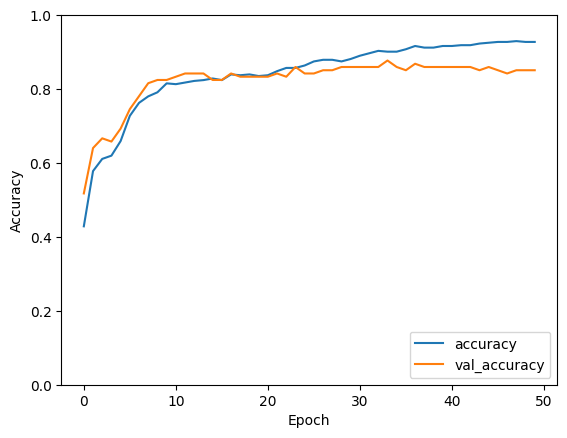

In [ ]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(Y_test, predictions) * 100:.2f}%")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_forest, X_new, y, cv=kf, scoring='accuracy')
print(scores)
print(f"Mean Accuracy: {scores.mean()}")

[0.8041958  0.81818182 0.83098592 0.88732394 0.78873239]
Mean Accuracy: 0.8258839751797499
